In [1]:
from qiskit import *
from math import log2, ceil
from qiskit.circuit.library import XGate, UnitaryGate
from qiskit.circuit import Gate

In [2]:
def encode_table(l: list[int], size: int) -> list[str]:
    """
    l: list to be encoded
    size: how many bits elements should have in it's encoding
    """
    encoded_l = []
    for num in l:
        encoded_l.append((bin(num)[2:]).rjust(size,"0")) 
    return encoded_l

l = [4,2,3,1,6,5,8,7]
print(encode_table(l, 4))

['0100', '0010', '0011', '0001', '0110', '0101', '1000', '0111']


In [3]:
def generate_control_strings(size: int) -> list[str]:
    """
    size: number of bits to encode list size
    """
    c_strings = []
    string_size = ceil(log2(size))
    for i in range(size):
        c_strings.append((bin(i)[2:]).rjust(string_size,"0"))
    return c_strings

print(generate_control_strings(6))

['000', '001', '010', '011', '100', '101']


In [4]:
def xor_data_gates(l: list[str], size: int) -> list[Gate]:
    """
    create a list of gates wich cnots the data in list to qubits
    """
    circuits = []
    for bit_string in l:
        qc = QuantumCircuit(size)
        for bit in range(len(bit_string)):
            if bit_string[bit] == "1":
                qc.x(abs(bit-size)-1)
        circuits.append(qc.to_gate())

    for i in range(len(circuits)):
        circuits[i].name = f"L{i}"
    return circuits

circs = xor_data_gates(['0100', '0010', '0011', '0001', '0110', '0101', '1000', '0111'], 4)

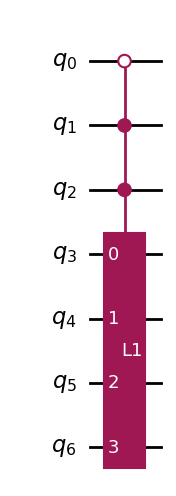

In [5]:
qc = QuantumCircuit(7)
qc.append(circs[1].control(3, ctrl_state="110"), [0,1,2,3,4,5,6])
qc.draw("mpl")

In [6]:
c_strings = generate_control_strings(6)
print("1" + c_strings[5])

1101


In [7]:
num = 9
print(ceil(log2(num)))

4


In [8]:
def calculate_exp_table(W: int, a: int, N: int, only_odds: bool = False) -> list[int]:
    exp_table = [0]*((1<<W))
    (step, start) = (2,1) if only_odds else (1,0)
    for d in range(start,(1<<W),step):
        exp_table[d] = ((a**d) % N)
    return exp_table

print(calculate_exp_table(2,3,31))

[1, 3, 9, 27]


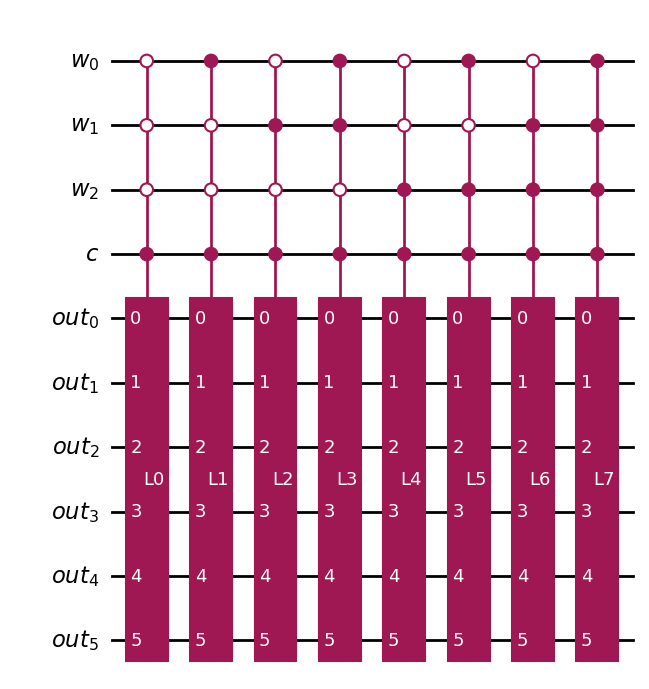

In [9]:
def compute_lookup_table(outBits: int, l: list[int], optimization: int = 0) -> QuantumCircuit:
    """
    a = input; input size in bits is log2(len(l)), ex: if len(l) = 8, then input size is 3, log2(8)=3, 2^3 = 8
    w = output size in bits
    l = table to be computed
    c = controll qubit
    """
    window_size = ceil(log2(len(l)))
    w = QuantumRegister(window_size, name="w")
    o = QuantumRegister(outBits, name="out")
    c = QuantumRegister(1, name="c")
    quantum_circuit = QuantumCircuit(w, c, o)

    c_strings = generate_control_strings(len(l))
    e_table = encode_table(l, outBits)
    x_circs = xor_data_gates(e_table, outBits)
    
    match optimization:
        case 0:
            for i in range(len(l)):
                get_data_circ = x_circs[i].control(window_size + 1, ctrl_state="1" + c_strings[i])
                quantum_circuit.append(get_data_circ, w[:] + c[:] + o[:])
    
    
    return quantum_circuit

compute_lookup_table(6, [0,0,0,0,0,0,0,0]).draw("mpl")

In [67]:
import re
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.qasm2 import dumps # Import dumps for saving QASM
from qiskit.circuit.library import MCXGate # Import MCXGate for multi-controlled X

def apply_toffoli_decomposition(circuit, controls, target):
    """
    Applies a multi-controlled Toffoli gate (arbitrary number of controls)
    using the Qiskit built-in CX and auxiliary qubits.
    (This function is largely superseded by MCXGate for multi-controls,
    but kept for T1, T2, T3 specific implementations if needed.)
    """
    if len(controls) == 0:
        # If no controls, it's just a NOT gate on the target
        circuit.x(target)
    elif len(controls) == 1:
        circuit.cx(controls[0], target)
    elif len(controls) == 2:
        circuit.ccx(controls[0], controls[1], target)
    else:
        # This case is now handled by the main parsing loop using MCXGate
        # if the gate type is 'T4', 'T5', etc.
        # This function won't be explicitly called for T4+ in the new parsing logic.
        pass


def tfc_to_qiskit(tfc_filepath, num_ctrl_qubits, output_qasm_filepath="output_circuit.qasm", output_drawing_filepath="output_circuit.txt"):
    """
    Converts a quantum circuit described in .tfc format to a Qiskit QuantumCircuit.

    Args:
        tfc_filepath (str): Path to the input .tfc file.
        output_qasm_filepath (str): Path to save the generated QASM file.
        output_drawing_filepath (str): Path to save the text drawing of the circuit.
    """
    qubit_map = {}
    next_qubit_index = 0
    num_classical_bits = 0
    circuit_lines = []

    try:
        with open(tfc_filepath, 'r') as f:
            lines = f.readlines()

        in_begin_section = False
        for line in lines:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            if line.startswith('.v'):
                virtual_qubits = [q.strip() for q in line.split(' ')[1].split(',')]
                for q_name in virtual_qubits:
                    if q_name.startswith('b'):
                        qubit_map[q_name] = next_qubit_index
                        next_qubit_index += 1
                    elif q_name.startswith('s'):
                        qubit_map[q_name] = next_qubit_index
                        next_qubit_index += 1
                        pass 
            elif line.startswith('.i'):
                pass
            elif line.startswith('.o'):
                output_qubit_names = [q.strip() for q in line.split(' ')[1].split(',')]
                num_classical_bits = len(output_qubit_names)
                pass
            elif line == 'BEGIN':
                in_begin_section = True
            elif line == 'END':
                in_begin_section = False
            elif in_begin_section:
                circuit_lines.append(line)

        actual_num_qubits = max(qubit_map.values()) + 1 if qubit_map else 0

        qr = QuantumRegister(actual_num_qubits, 'q')
        #cr = ClassicalRegister(num_classical_bits, 'c')
        qc = QuantumCircuit(qr)

        print(f"Total Quantum Qubits: {actual_num_qubits}")
        print(f"Total Classical Bits (for outputs): {num_classical_bits}")
        print("Qubit Mapping:", qubit_map)

        for gate_line in circuit_lines:
            match = re.match(r'(T\d+)\s(.*)', gate_line)
            if not match:
                print(f"Warning: Could not parse line: {gate_line}")
                continue

            gate_type = match.group(1)
            qubit_names_str = match.group(2)
            qubit_names = [q.strip() for q in qubit_names_str.split(',')]

            controls = []
            target_idx = None
            control_states_str = "" # To build the control_state string for MCXGate

            # The last qubit in T gates is generally the target.
            target_name_raw = qubit_names[-1]
            if target_name_raw.endswith("'"):
                print(f"Warning: Target qubit '{target_name_raw}' is negated. A target qubit cannot be negated in standard controlled gates. This might indicate an issue in the TFC specification or an unconventional gate.")
                # For now, we will treat the target as non-negated.
                target_name = target_name_raw[:-1]
            else:
                target_name = target_name_raw

            target_idx = qubit_map.get(target_name)
            if target_idx is None:
                print(f"Error: Target qubit '{target_name}' not found in qubit map for line: {gate_line}")
                continue


            # The rest are controls
            for q_name_raw in qubit_names[:-1]:
                is_negated = False
                q_name = q_name_raw
                if q_name_raw.endswith("'"):
                    is_negated = True
                    q_name = q_name_raw[:-1] # Remove the prime for mapping

                control_idx = qubit_map.get(q_name)
                if control_idx is None:
                    print(f"Error: Control qubit '{q_name}' not found in qubit map for line: {gate_line}")
                    continue

                controls.append(qr[num_ctrl_qubits-control_idx-1]) # Add QuantumRegister object
                control_states_str += '0' if is_negated else '1'


            # Apply gates based on their type and number of qubits
            if gate_type == 'T1':
                # T1 is a NOT gate (X gate)
                qc.x(qr[target_idx]) # Ensure it's a Qubit object

            elif gate_type == 'T2':
                # T2 is a CNOT gate (CX gate)
                if len(controls) != 1:
                    print(f"Warning: T2 gate expects 1 control, found {len(controls)} for {gate_line}. Skipping.")
                    continue
                
                # Use CX directly. For negated controls, apply X gates around.
                # This logic is simpler than MCXGate for just one control.
                if control_states_str[0] == '0':
                    qc.x(controls[0])
                qc.cx(controls[0], qr[target_idx])
                if control_states_str[0] == '0':
                    qc.x(controls[0])

            elif gate_type == 'T3':
                # T3 is a Toffoli gate (CCX gate)
                if len(controls) != 2:
                    print(f"Warning: T3 gate expects 2 controls, found {len(controls)} for {gate_line}. Skipping.")
                    continue
                
                # Use CCX directly. For negated controls, apply X gates around.
                # This logic is simpler than MCXGate for just two controls.
                temp_controls = list(controls) # Create a mutable copy
                for i, control_state in enumerate(control_states_str):
                    if control_state == '0':
                        qc.x(temp_controls[i])

                qc.ccx(temp_controls[0], temp_controls[1], qr[target_idx])

                # Revert X gates
                for i, control_state in enumerate(control_states_str):
                    if control_state == '0':
                        qc.x(temp_controls[i])

            # For T4, T5, etc., use MCXGate
            elif gate_type.startswith('T'):
                num_involved_qubits = int(gate_type[1:])
                if len(controls) + 1 != num_involved_qubits:
                    print(f"Warning: Gate {gate_type} in line '{gate_line}' implies {num_involved_qubits} qubits, but found {len(controls)+1}. Continuing with available qubits.")
                
                # Create the MCXGate object. It takes the number of controls and the control_state string.
                mcx_gate = MCXGate(len(controls), ctrl_state=control_states_str[::-1])
                
                # All qubits involved in the gate: controls first, then the target.
                all_involved_qubits = controls + [qr[target_idx]]
                
                # Append the MCXGate to the circuit
                qc.append(mcx_gate, all_involved_qubits)

            else:
                print(f"Warning: Unknown gate type {gate_type} in line: {gate_line}")

        # Measure output qubits
        output_qubit_names_from_o_line = []
        for line in lines:
            if line.startswith('.o'):
                output_qubit_names_from_o_line = [q.strip() for q in line.split(' ')[1].split(',')]
                break

        s_name_to_c_bit_idx = {name: i for i, name in enumerate(output_qubit_names_from_o_line)}

        for q_name in output_qubit_names_from_o_line:
            q_idx = qubit_map.get(q_name)
            c_idx = s_name_to_c_bit_idx.get(q_name)

            # if q_idx is not None and c_idx is not None:
            #     if q_idx < actual_num_qubits and c_idx < num_classical_bits:
            #         qc.measure(qr[q_idx], cr[c_idx])
            #     else:
            #         print(f"Warning: Qubit {q_name} (index {q_idx}) or classical bit {c_idx} out of bounds for measurement.")
            # else:
            #     print(f"Warning: Output qubit '{q_name}' not found in qubit map or classical bit mapping.")


        # Save the circuit drawing to a file
        # with open(output_drawing_filepath, 'w') as f:
        #     f.write(qc.draw(output='text', fold=-1))

        # Save the circuit as QASM using qiskit.qasm2.dumps
        # with open(output_qasm_filepath, 'w') as f:
        #     f.write(dumps(qc))

        print(f"\nCircuit successfully created and saved sto '{output_qasm_filepath}' and '{output_drawing_filepath}'.")

    except FileNotFoundError:
        print(f"Error: The file '{tfc_filepath}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

    return qc

# --- How to use the script ---
tfc_file = "expmod15.tfc" # Make sure this file exists in the same directory
# Call the function without .draw("mpl") as it modifies the return value
qromteste15 = tfc_to_qiskit(tfc_file, 2*4)

Total Quantum Qubits: 12
Total Classical Bits (for outputs): 12
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4, 'b5': 5, 'b6': 6, 'b7': 7, 'b8': 8, 'b9': 9, 'b10': 10, 'b11': 11}

Circuit successfully created and saved sto 'output_circuit.qasm' and 'output_circuit.txt'.


In [68]:
N = 15
n = int(log2(N)) + 1
tabela_ints = calculate_exp_table(2*n, 2, N)
print(tabela_ints)
len(tabela_ints)

[1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8]


256

In [61]:
qrom15 = compute_lookup_table(n, tabela_ints)

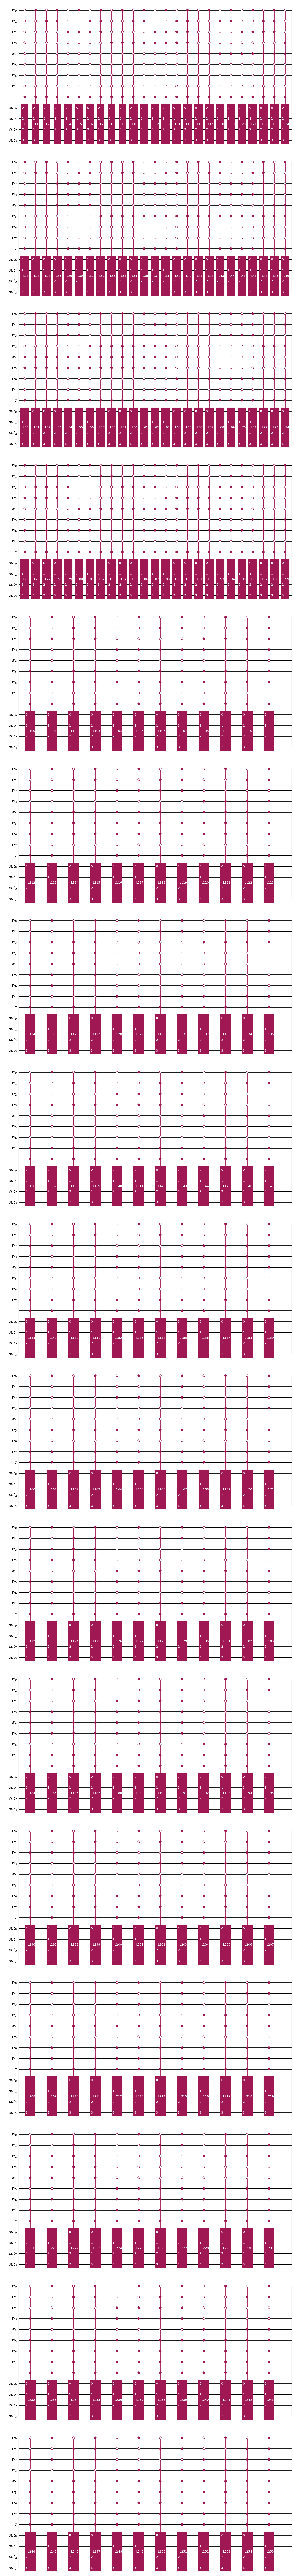

In [62]:
qrom15.draw("mpl")

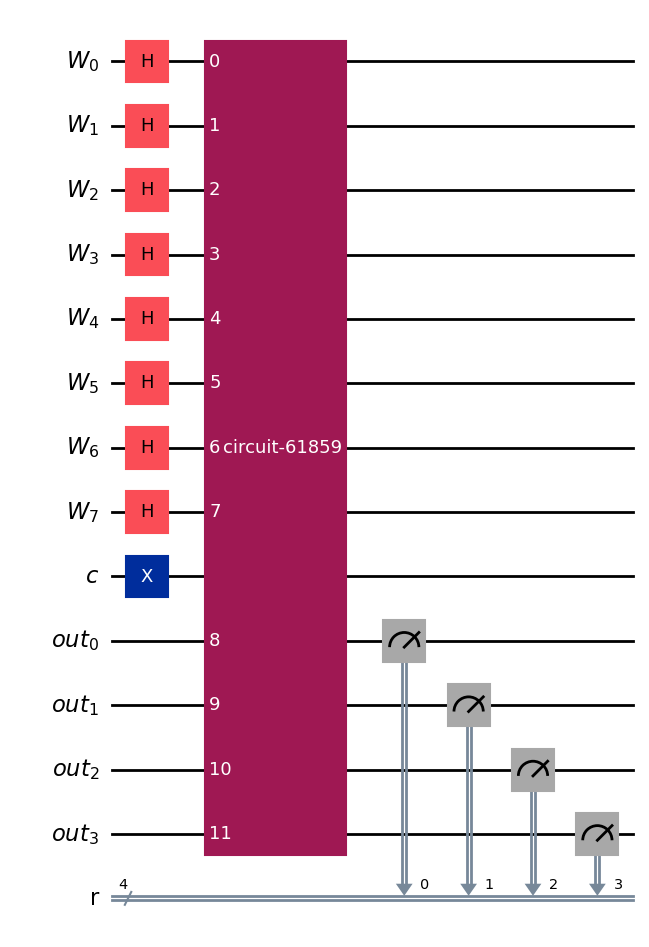

In [72]:
reg1 = QuantumRegister(2*n, "W")
reg2 = QuantumRegister(1, "c")
reg3 = QuantumRegister(n, "out")
reg4 = ClassicalRegister(n, "r")
qc = QuantumCircuit(reg1,reg2,reg3, reg4)
qc.h(reg1)
qc.x(reg2)

#qc.append(qrom15, reg1[:] + reg2[:] + reg3[:])
qc.append(qromteste15, reg1[:] + reg3[:])

qc.measure(reg3[:], reg4)
qc.draw("mpl")

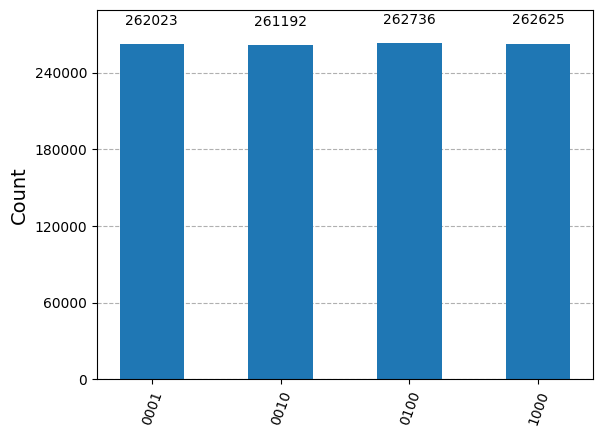

In [73]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

simulator_aer = AerSimulator()

qc_aer = transpile(qc, backend=simulator_aer)

job = simulator_aer.run(qc_aer, shots=(1<<20))
job_result = job.result()
counts = job_result.get_counts(qc_aer)

plot_histogram(counts)

In [74]:
from qiskit.circuit.library import QFT

reg1 = QuantumRegister(2*n, "W")
reg2 = QuantumRegister(1, "c")
reg3 = QuantumRegister(n, "out")
reg4 = ClassicalRegister(2*n, "r")
qc = QuantumCircuit(reg1,reg2,reg3, reg4)
qc.h(reg1)
qc.x(reg2)
#qc.append(qrom15, reg1[:] + reg2[:]+ reg3[:]) 
qc.append(qromteste15, reg1[:] + reg3[:]) 
qc.append(QFT(2*n, inverse=True), reg1[:])
qc.measure(reg1, reg4)

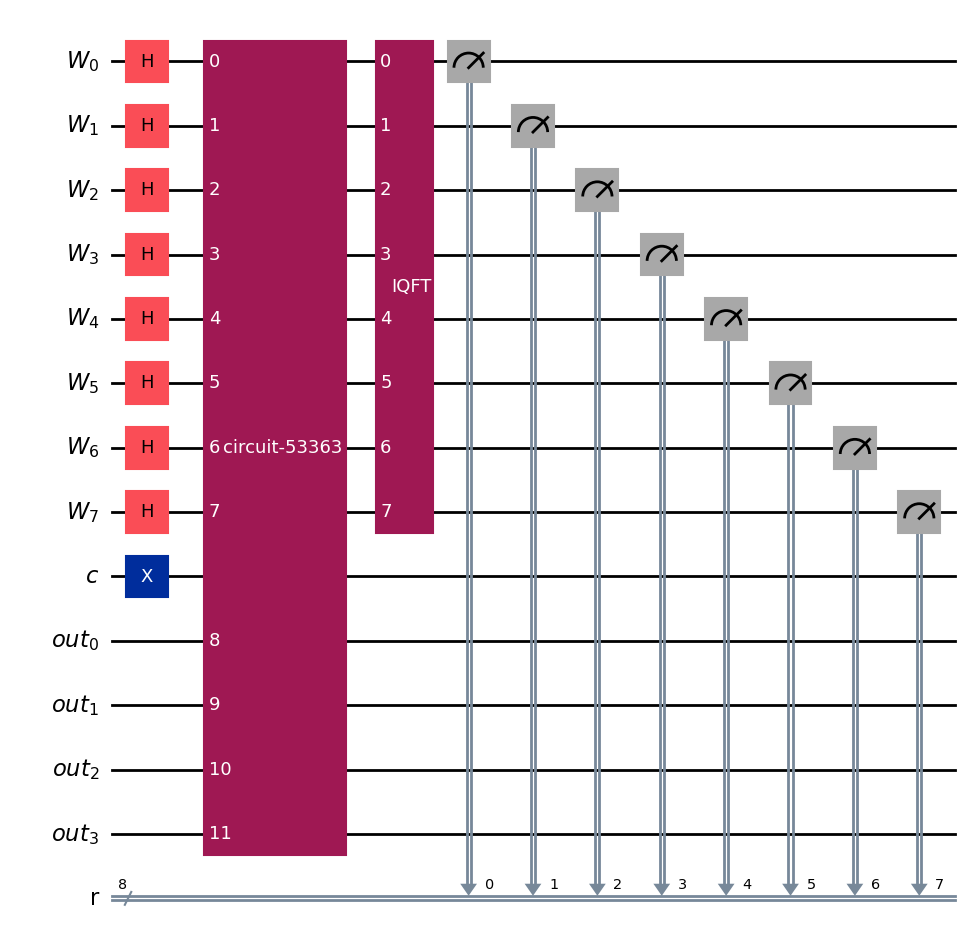

In [46]:
qc.draw("mpl")

In [75]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)

counts = job.result()[0].data.r.get_int_counts()
for i in range(1<<(2*n)):
  if i not in counts:
    counts[i] = 0

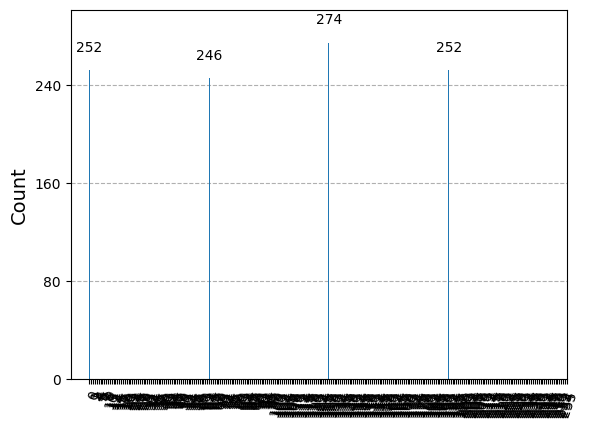

In [76]:
plot_histogram(counts)

In [82]:
N = 35
n = int(log2(N)) + 1
tabela_ints = calculate_exp_table(2*n, 2, N)
print(tabela_ints)
len(tabela_ints)

[1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8, 16, 32, 29, 23, 11, 22, 9, 18, 1, 2, 4, 8

4096

In [15]:
qrom35 = compute_lookup_table(n, tabela_ints)

In [ ]:
import re
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.qasm2 import dumps # Import dumps for saving QASM
from qiskit.circuit.library import MCXGate # Import MCXGate for multi-controlled X

def apply_toffoli_decomposition(circuit, controls, target):
    """
    Applies a multi-controlled Toffoli gate (arbitrary number of controls)
    using the Qiskit built-in CX and auxiliary qubits.
    (This function is largely superseded by MCXGate for multi-controls,
    but kept for T1, T2, T3 specific implementations if needed.)
    """
    if len(controls) == 0:
        # If no controls, it's just a NOT gate on the target
        circuit.x(target)
    elif len(controls) == 1:
        circuit.cx(controls[0], target)
    elif len(controls) == 2:
        circuit.ccx(controls[0], controls[1], target)
    else:
        # This case is now handled by the main parsing loop using MCXGate
        # if the gate type is 'T4', 'T5', etc.
        # This function won't be explicitly called for T4+ in the new parsing logic.
        pass


def tfc_to_qiskit(tfc_filepath, num_ctrl_qubits, output_qasm_filepath="output_circuit.qasm", output_drawing_filepath="output_circuit.txt"):
    """
    Converts a quantum circuit described in .tfc format to a Qiskit QuantumCircuit.

    Args:
        tfc_filepath (str): Path to the input .tfc file.
        output_qasm_filepath (str): Path to save the generated QASM file.
        output_drawing_filepath (str): Path to save the text drawing of the circuit.
    """
    qubit_map = {}
    next_qubit_index = 0
    num_classical_bits = 0
    circuit_lines = []

    try:
        with open(tfc_filepath, 'r') as f:
            lines = f.readlines()

        in_begin_section = False
        for line in lines:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            if line.startswith('.v'):
                virtual_qubits = [q.strip() for q in line.split(' ')[1].split(',')]
                for q_name in virtual_qubits:
                    if q_name.startswith('b'):
                        qubit_map[q_name] = next_qubit_index
                        next_qubit_index += 1
                    elif q_name.startswith('s'):
                        qubit_map[q_name] = next_qubit_index
                        next_qubit_index += 1
                        pass 
            elif line.startswith('.i'):
                pass
            elif line.startswith('.o'):
                output_qubit_names = [q.strip() for q in line.split(' ')[1].split(',')]
                num_classical_bits = len(output_qubit_names)
                pass
            elif line == 'BEGIN':
                in_begin_section = True
            elif line == 'END':
                in_begin_section = False
            elif in_begin_section:
                circuit_lines.append(line)

        actual_num_qubits = max(qubit_map.values()) + 1 if qubit_map else 0

        qr = QuantumRegister(actual_num_qubits, 'q')
        #cr = ClassicalRegister(num_classical_bits, 'c')
        qc = QuantumCircuit(qr)

        print(f"Total Quantum Qubits: {actual_num_qubits}")
        print(f"Total Classical Bits (for outputs): {num_classical_bits}")
        print("Qubit Mapping:", qubit_map)

        for gate_line in circuit_lines:
            match = re.match(r'(T\d+)\s(.*)', gate_line)
            if not match:
                print(f"Warning: Could not parse line: {gate_line}")
                continue

            gate_type = match.group(1)
            qubit_names_str = match.group(2)
            qubit_names = [q.strip() for q in qubit_names_str.split(',')]

            controls = []
            target_idx = None
            control_states_str = "" # To build the control_state string for MCXGate

            # The last qubit in T gates is generally the target.
            target_name_raw = qubit_names[-1]
            if target_name_raw.endswith("'"):
                print(f"Warning: Target qubit '{target_name_raw}' is negated. A target qubit cannot be negated in standard controlled gates. This might indicate an issue in the TFC specification or an unconventional gate.")
                # For now, we will treat the target as non-negated.
                target_name = target_name_raw[:-1]
            else:
                target_name = target_name_raw

            target_idx = qubit_map.get(target_name)
            if target_idx is None:
                print(f"Error: Target qubit '{target_name}' not found in qubit map for line: {gate_line}")
                continue


            # The rest are controls
            for q_name_raw in qubit_names[:-1]:
                is_negated = False
                q_name = q_name_raw
                if q_name_raw.endswith("'"):
                    is_negated = True
                    q_name = q_name_raw[:-1] # Remove the prime for mapping

                control_idx = qubit_map.get(q_name)
                if control_idx is None:
                    print(f"Error: Control qubit '{q_name}' not found in qubit map for line: {gate_line}")
                    continue

                controls.append(qr[num_ctrl_qubits-control_idx-1]) # Add QuantumRegister object
                control_states_str += '0' if is_negated else '1'


            # Apply gates based on their type and number of qubits
            if gate_type == 'T1':
                # T1 is a NOT gate (X gate)
                qc.x(qr[target_idx]) # Ensure it's a Qubit object

            elif gate_type == 'T2':
                # T2 is a CNOT gate (CX gate)
                if len(controls) != 1:
                    print(f"Warning: T2 gate expects 1 control, found {len(controls)} for {gate_line}. Skipping.")
                    continue
                
                # Use CX directly. For negated controls, apply X gates around.
                # This logic is simpler than MCXGate for just one control.
                if control_states_str[0] == '0':
                    qc.x(controls[0])
                qc.cx(controls[0], qr[target_idx])
                if control_states_str[0] == '0':
                    qc.x(controls[0])

            elif gate_type == 'T3':
                # T3 is a Toffoli gate (CCX gate)
                if len(controls) != 2:
                    print(f"Warning: T3 gate expects 2 controls, found {len(controls)} for {gate_line}. Skipping.")
                    continue
                
                # Use CCX directly. For negated controls, apply X gates around.
                # This logic is simpler than MCXGate for just two controls.
                temp_controls = list(controls) # Create a mutable copy
                for i, control_state in enumerate(control_states_str):
                    if control_state == '0':
                        qc.x(temp_controls[i])

                qc.ccx(temp_controls[0], temp_controls[1], qr[target_idx])

                # Revert X gates
                for i, control_state in enumerate(control_states_str):
                    if control_state == '0':
                        qc.x(temp_controls[i])

            # For T4, T5, etc., use MCXGate
            elif gate_type.startswith('T'):
                num_involved_qubits = int(gate_type[1:])
                if len(controls) + 1 != num_involved_qubits:
                    print(f"Warning: Gate {gate_type} in line '{gate_line}' implies {num_involved_qubits} qubits, but found {len(controls)+1}. Continuing with available qubits.")
                
                # Create the MCXGate object. It takes the number of controls and the control_state string.
                mcx_gate = MCXGate(len(controls), ctrl_state=control_states_str[::-1])
                
                # All qubits involved in the gate: controls first, then the target.
                all_involved_qubits = controls + [qr[target_idx]]
                
                # Append the MCXGate to the circuit
                qc.append(mcx_gate, all_involved_qubits)

            else:
                print(f"Warning: Unknown gate type {gate_type} in line: {gate_line}")

        # Measure output qubits
        output_qubit_names_from_o_line = []
        for line in lines:
            if line.startswith('.o'):
                output_qubit_names_from_o_line = [q.strip() for q in line.split(' ')[1].split(',')]
                break

        s_name_to_c_bit_idx = {name: i for i, name in enumerate(output_qubit_names_from_o_line)}

        for q_name in output_qubit_names_from_o_line:
            q_idx = qubit_map.get(q_name)
            c_idx = s_name_to_c_bit_idx.get(q_name)

            # if q_idx is not None and c_idx is not None:
            #     if q_idx < actual_num_qubits and c_idx < num_classical_bits:
            #         qc.measure(qr[q_idx], cr[c_idx])
            #     else:
            #         print(f"Warning: Qubit {q_name} (index {q_idx}) or classical bit {c_idx} out of bounds for measurement.")
            # else:
            #     print(f"Warning: Output qubit '{q_name}' not found in qubit map or classical bit mapping.")


        # Save the circuit drawing to a file
        # with open(output_drawing_filepath, 'w') as f:
        #     f.write(qc.draw(output='text', fold=-1))

        # Save the circuit as QASM using qiskit.qasm2.dumps
        # with open(output_qasm_filepath, 'w') as f:
        #     f.write(dumps(qc))

        #print(f"\nCircuit successfully created and saved to '{output_qasm_filepath}' and '{output_drawing_filepath}'.")

    except FileNotFoundError:
        print(f"Error: The file '{tfc_filepath}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

    return qc

# --- How to use the script ---
tfc_file = "expmod35.tfc" # Make sure this file exists in the same directory
# Call the function without .draw("mpl") as it modifies the return value
qromteste35 = tfc_to_qiskit(tfc_file, 2*6)

Total Quantum Qubits: 18
Total Classical Bits (for outputs): 6
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4, 'b5': 5, 'b6': 6, 'b7': 7, 'b8': 8, 'b9': 9, 'b10': 10, 'b11': 11, 's0': 12, 's1': 13, 's2': 14, 's3': 15, 's4': 16, 's5': 17}

Circuit successfully created and saved to 'output_circuit.qasm' and 'output_circuit.txt'.


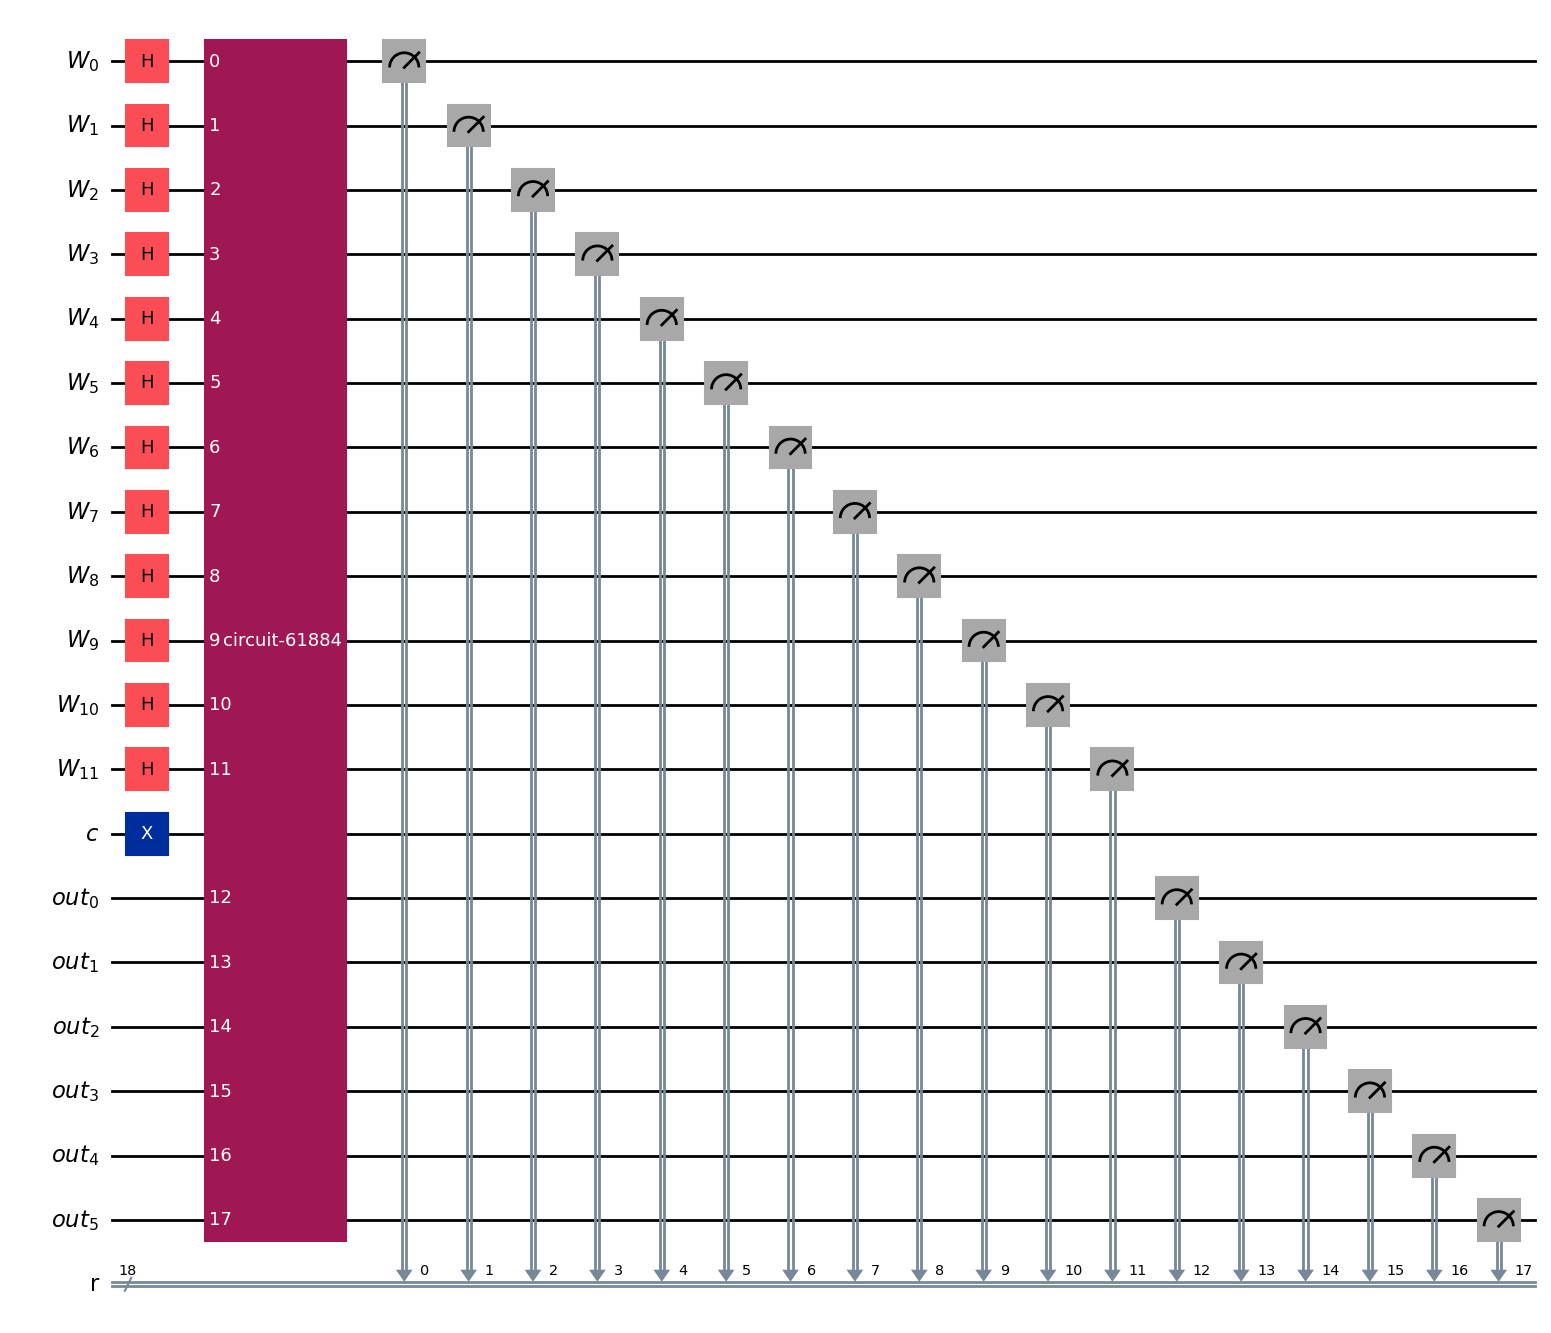

In [83]:
reg1 = QuantumRegister(2*n, "W")
reg2 = QuantumRegister(1, "c")
reg3 = QuantumRegister(n, "out")
reg4 = ClassicalRegister(3*n, "r")
qc = QuantumCircuit(reg1,reg2,reg3, reg4)
qc.h(reg1)
qc.x(reg2)

qc.append(qromteste35, reg1[:] + reg3[:])

#qc.append(qrom35, reg1[:] + reg2[:] + reg3[:])
qc.measure(reg1[:] + reg3[:], reg4)
qc.draw("mpl")

[(0, 1), (1, 2), (2, 4), (3, 8), (4, 16), (5, 32), (6, 29), (7, 23), (8, 11), (9, 22), (10, 9), (11, 18), (12, 1), (13, 2), (14, 4), (15, 8), (16, 16), (17, 32), (18, 29), (19, 23), (20, 11), (21, 22), (22, 9), (23, 18), (24, 1), (25, 2), (26, 4), (27, 8), (28, 16), (29, 32), (30, 29), (31, 23), (32, 11), (33, 22), (34, 9), (35, 18), (36, 1), (37, 2), (38, 4), (39, 8), (40, 16), (41, 32), (42, 29), (43, 23), (44, 11), (45, 22), (46, 9), (47, 18), (48, 1), (49, 2), (50, 4), (51, 8), (52, 16), (53, 32), (54, 29), (55, 23), (56, 11), (57, 22), (58, 9), (59, 18), (60, 1), (61, 2), (62, 4), (63, 8), (64, 16), (65, 32), (66, 29), (67, 23), (68, 11), (69, 22), (70, 9), (71, 18), (72, 1), (73, 2), (74, 4), (75, 8), (76, 16), (77, 32), (78, 29), (79, 23), (80, 11), (81, 22), (82, 9), (83, 18), (84, 1), (85, 2), (86, 4), (87, 8), (88, 16), (89, 32), (90, 29), (91, 23), (92, 11), (93, 22), (94, 9), (95, 18), (96, 1), (97, 2), (98, 4), (99, 8), (100, 16), (101, 32), (102, 29), (103, 23), (104, 11)

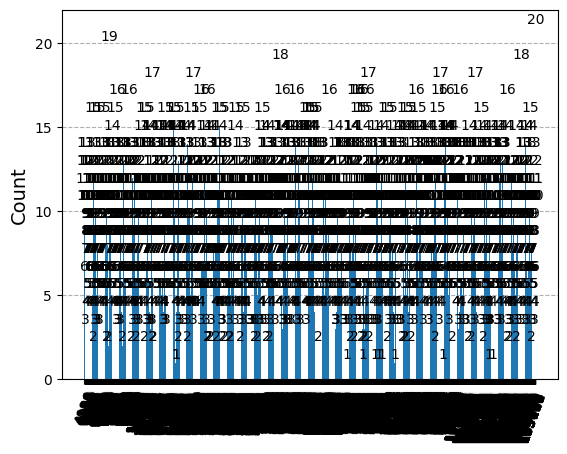

In [84]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1<<15)

counts = job.result()[0].data.r.get_int_counts()
resp = job.result()[0].data.r.get_counts()

l = []
d = {}

for i in resp:
    x = int(i[6:], 2)
    b = int(i[:6], 2)
    l.append((x, b))
    d[x] = b

l.sort(key= lambda x: x[0])

print(l)
print(d)

plot_histogram(counts)

In [85]:
from qiskit.circuit.library import QFT

reg1 = QuantumRegister(2*n, "W")
reg2 = QuantumRegister(1, "c")
reg3 = QuantumRegister(n, "out")
reg4 = ClassicalRegister(2*n, "r")
qc = QuantumCircuit(reg1,reg2,reg3, reg4)
qc.h(reg1)
qc.x(reg2)
qc.append(qromteste35, reg1[:] + reg3[:])
# qc.append(qrom35, reg1[:] + reg2[:] + reg3[:])
qc.append(QFT(2*n, inverse=True), reg1[:])
qc.measure(reg1, reg4)

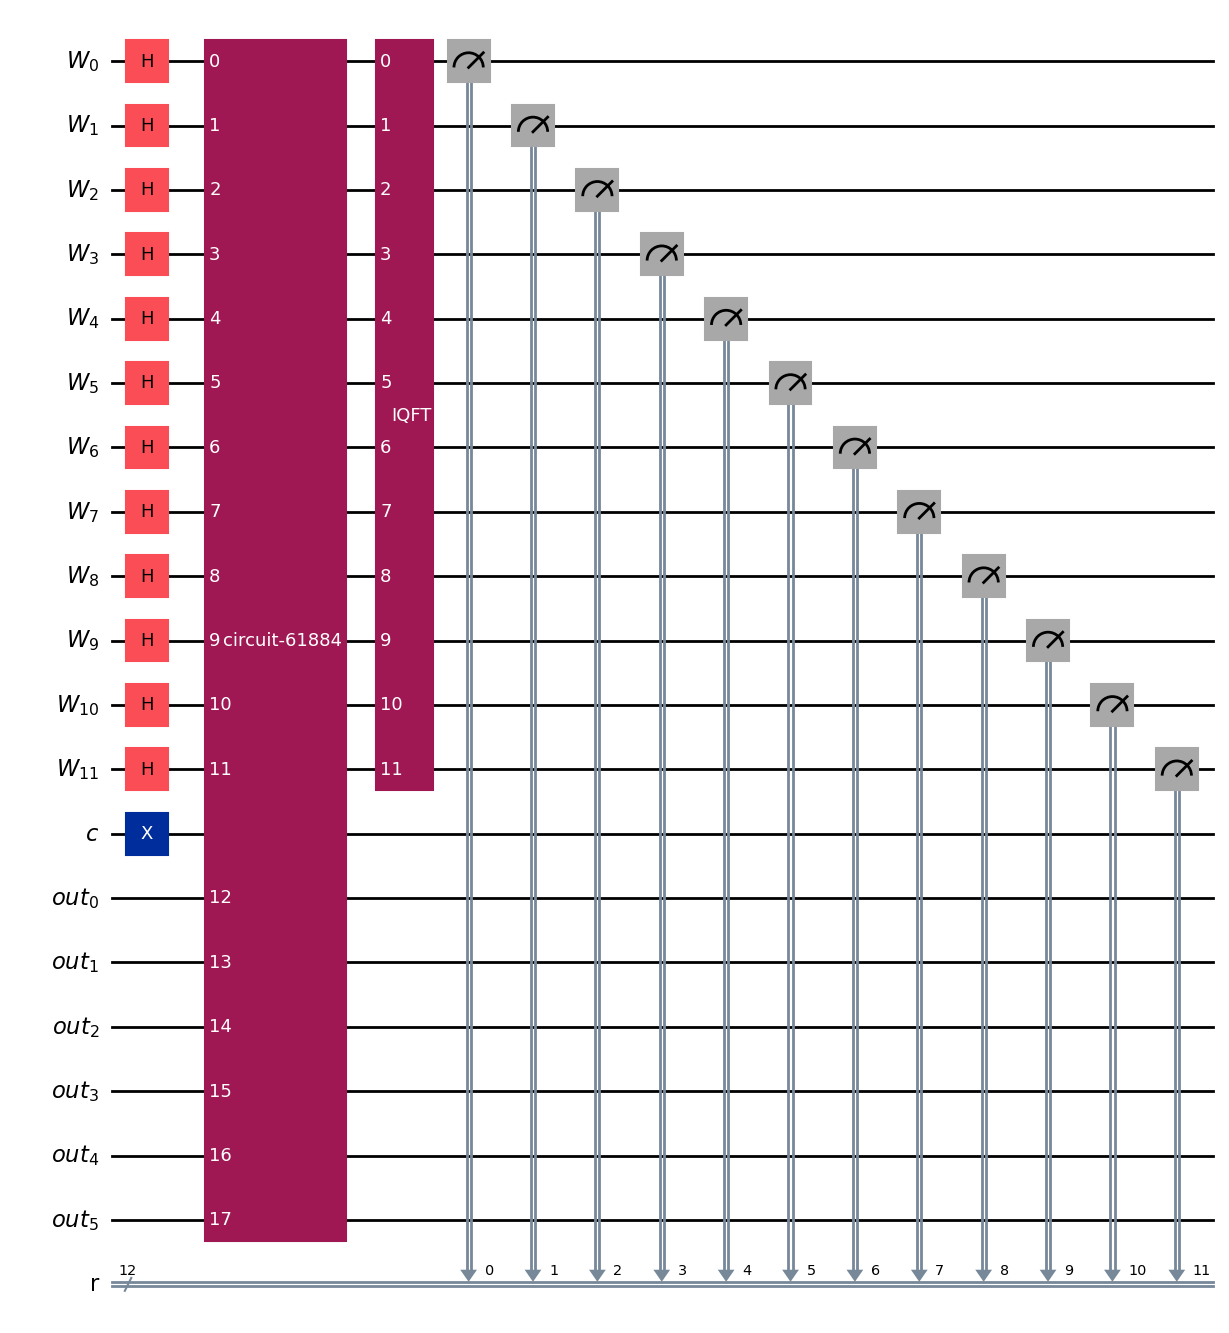

In [86]:
qc.draw("mpl")

In [87]:
backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)

counts = job.result()[0].data.r.get_int_counts()
#for i in range(1<<(2*n)):
#  if i not in counts:
#    counts[i] = 0

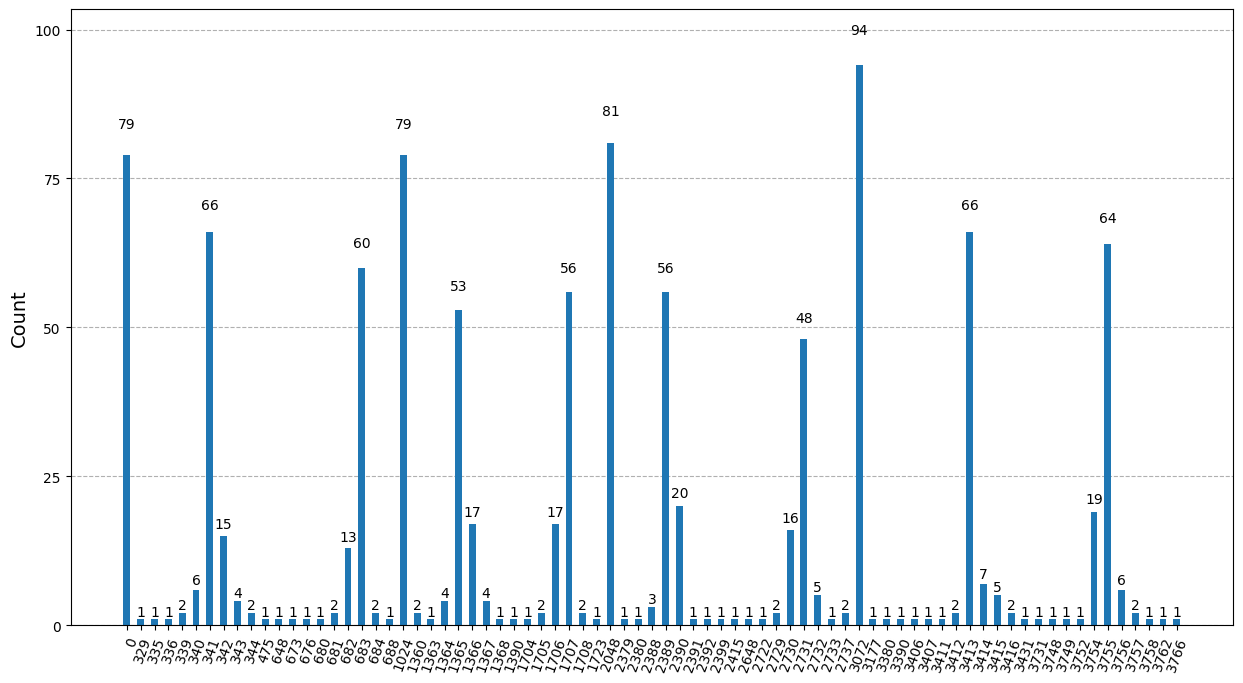

In [88]:
plot_histogram(counts, figsize=[15,8])